In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd /content/drive/My Drive/проект/

/content/drive/My Drive/проект


In [ ]:
%%capture
!unzip Class.zip
!mv Class class_train
!find class_train/Berry -size 0 -print0 |xargs -0 rm --
!find class_train/Mushroom -size 0 -print0 |xargs -0 rm --

In [ ]:
from glob import glob
from sklearn.model_selection import train_test_split

berry1=glob('class_train/Berry/*.jpg')
mushroom=glob('class_train/Mushroom/*.jpg')

berry=berry1[-1144:]

berry_train, berry_test, mushroom_train, mushroom_test =train_test_split(berry, mushroom, test_size=0.01, random_state=42)

TRAIN_DIR='class_train'
TEST_DIR='class_test'

!mkdir class_test

!mkdir class_test/Berry
files=' '.join(berry_test)
!mv -t class_test/Berry $files

!mkdir class_test/Mushroom
files=' '.join(mushroom_test)
!mv -t class_test/Mushroom $files

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `mv -t class_test/Berry class_train/Berry/5b0d060e9545a.jpg class_train/Berry/IMG_4479.jpg class_train/Berry/fhif0jVEncQ.jpg class_train/Berry/images (2).jpg class_train/Berry/ab.jpg class_train/Berry/g (3).jpg class_train/Berry/v25.jpg class_train/Berry/203349.56276.jpg class_train/Berry/images (49).jpg class_train/Berry/4.jpg class_train/Berry/Apfelbaum_oben.jpg class_train/Berry/b13.jpg'


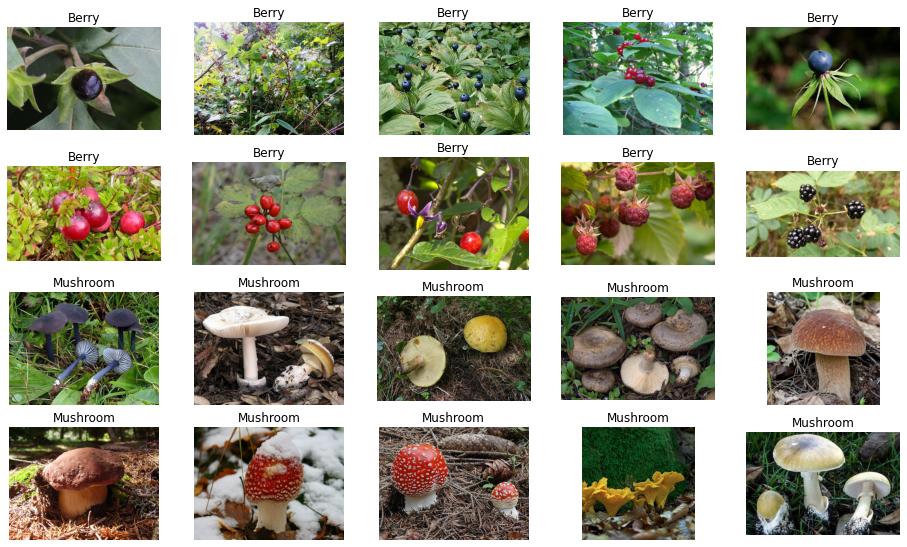

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

berry=np.random.choice(berry_train,10)
mushroom=np.random.choice(mushroom_train, 10)
data=np.concatenate((berry,mushroom))     #соединяет массивы вдоль указанной оси, возвращает массив
labels=10*['Berry']+10*['Mushroom']  

N, R, C = 25, 5, 5
plt.figure(figsize=(16,12))           #графический обьект, ширина 12 высота 9
for k,(src,label) in enumerate(zip(data,labels)):  #цикл применяет к итерируемой коллекци функцию, которая создает обьект (кортеж), состоящий из индекса элемента и самого элемента
  im=Image.open(src).convert('RGB')     #открывает и идентифицирует данный файл изображения          
  plt.subplot(R, C, k+1)   #создает фигиру и набор вложенных диаграмм 
  plt.title(label)
  plt.imshow(np.asarray(im))
  plt.axis('off')  #указывет ось

In [ ]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout  #собираем слои(layers) для построения модели. обьединение пространственных данных.Dropout для борьбы с переобучением
from keras.applications.inception_v3 import InceptionV3, preprocess_input #нейронная сеть. 

CLASSES=2

base_model=InceptionV3(weights='imagenet', include_top=False) #используем модель, обученную на базе изображений imagenet (загрузили обученные веса). верхняя часть сетки выключена. 

x=base_model.output    #output - список выходных тензоров модели (тензор-основная структура данных в tensorflow; способ представления данных в глубоком обучении (n-ьерный массив))
x=GlobalAveragePooling2D(name='avg_pool')(x)  #операция средней подвыборки, изменяет масштаб?; 
x=Dropout(0.4)(x)  
predictions=Dense(CLASSES, activation='softmax')(x)  # softmax -имя встроенной функции (активации), возвращает вероятность принадлежности изображения к классу
model=Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:   #model.layers - плоский список слоев, составляющих модель
  layer.trainable=False

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Using TensorFlow backend.


87916544/87910968 [==============================] - 3s 0us/step


In [ ]:
from keras.preprocessing.image import ImageDataGenerator #предобработка изображения 

WIDTH = 299
HEIGHT = 299
BATCH_SIZE = 32 #размер партии???

# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,        
    height_shift_range=0.2,
    shear_range=0.2,              #интесивность сдвига (угол сдвига против часовйо стрелки в градусах)
    zoom_range=0.2,                # диапазон для случайного увеличения 
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 2288 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


**preprocessing_function:** функция, которая будет применяться в каждом входе; будет выполняться после изменения и дополнения размера изображения; принмает один аргумент - одно изображение и ввыводит тензор Numpy той же формы.

> 
**width_shift_range:** доля общей ширины, если <1, или пикселей, если >=1.

> 
**height_shift_range:** доля общей высоты, если <1, или пикселей, если >=1.

>
**shear_range:** поплавок; интенсивность сдвига (угол сдвига против часовой стрелки в градусах).

> 
**zoom_range:** диапазон для случайного увеличения.

> 
**horizontal_flip:** булева; случайный ввод сальто по горизонтали.

> 
**fill_model:** по умолчанию nearest; точки за пределами входа заполняются в соотвествии с заданным режимом : aaaaa|abcd|dddddd

> 
**flow_from_directory:** вводит путь к каталогу и генерирует пакеты дополнительных данных; directory -строка, путь к целому каталогу, должен срдержать по одному каталогу на класс;  target_size - кортеж целых чисел (высота, ширина) по умолчанию (256,256), размеры, до которых все найденные изображения будут изменены;  batch_size - размер пакетов данных (по умолчанию 32); class_mode - определяет тип возвращаемых массивов метки (categorical это двухмерные одноразовые кодированные метки). Возвращает кортеж (х,у): где х - нумерованный массив, содержащий пакет излбражений с формой (batch_size, target_size, channels), а у - нумерованный массив соответсв меток.










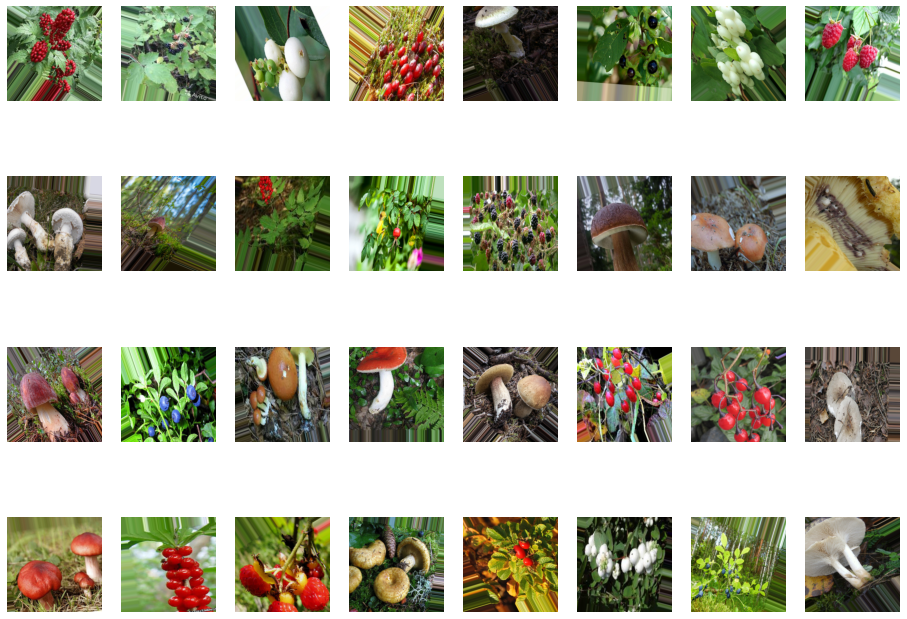

In [ ]:
x_batch, y_batch = next(train_generator)   #?

plt.figure(figsize=(16, 12))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

In [ ]:
EPOCHS = 6
BATCH_SIZE = 32
STEPS_PER_EPOCH = 320
VALIDATION_STEPS = 64

MODEL_FILE = 'filename_class_1.h5'

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

Epoch 1/6
320/320 [==============================] - 340s 1s/step - loss: 0.1879 - accuracy: 0.9268 - val_loss: 0.0552 - val_accuracy: 0.9720
Epoch 2/6
320/320 [==============================] - 324s 1s/step - loss: 0.0856 - accuracy: 0.9692 - val_loss: 0.0060 - val_accuracy: 0.9993
Epoch 3/6
320/320 [==============================] - 326s 1s/step - loss: 0.0782 - accuracy: 0.9718 - val_loss: 0.0022 - val_accuracy: 0.9961
Epoch 4/6
320/320 [==============================] - 325s 1s/step - loss: 0.0697 - accuracy: 0.9763 - val_loss: 0.0065 - val_accuracy: 0.9896
Epoch 5/6
320/320 [==============================] - 325s 1s/step - loss: 0.0696 - accuracy: 0.9737 - val_loss: 0.0047 - val_accuracy: 0.9987
Epoch 6/6
320/320 [==============================] - 323s 1s/step - loss: 0.0681 - accuracy: 0.9750 - val_loss: 0.0136 - val_accuracy: 0.9954


**fit_generator:** поставляет модель на основе данных, сгенерированных пакетно по пакетам генератором Python. Генератор работает параллельно с моделью для большей эффекивности; ***generator*** - генератор или экземпляр обьекта Model, чтобы исбежать дублирования данных при использовании многопроцессорной обработки (выходной сигнал генератора должен быть котреж); ***steps_per_epoch*** - целое, общее кол-во шагов (партий образцов) для выхода из генератора до обьявления одной эпохи законченной и начала следующей; ***epochs*** - целое, кол-во эпох для обучения модели (эпоха - это итерация по всем предоставленным данным, определяемая с помощью функции step_per_epoch); ***validation_data*** - это может быть generator (или др), по которым оценивают потери и любые метрики модели в конце каждой эпохи, модель не будет обучена работе с этими данными; ***validation_steps*** - (только если v_data был генератор), общее кол-во шагов (партий сэмплов) для получения данных из генератора valid_data до остановки в конце каждой эпохи, обычно оно равно кол-ву отсчетов вашего набора данных валидации, деленному на размер партии. Возвращает обьект history, история - это запись значений потерь обучения и значений метрики в последовательные эпохи.

In [ ]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


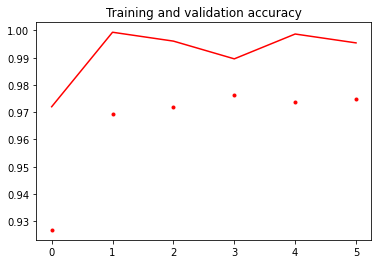

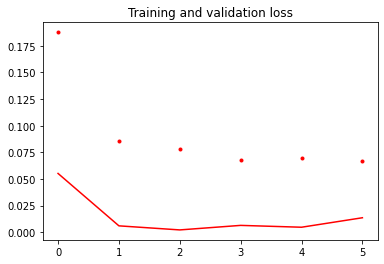

In [ ]:
def plot_training(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))   #range() генерирует ряд чисел в рамках заданного диапазона (от 0 до длины acc)
  
  plt.plot(epochs, acc, 'r.')
  plt.plot(epochs, val_acc, 'r')
  plt.title('Training and validation accuracy')
  
  plt.figure()
  plt.plot(epochs, loss, 'r.')
  plt.plot(epochs, val_loss, 'r-')
  plt.title('Training and validation loss')
  plt.show()
  
plot_training(history)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from keras.preprocessing import image
from keras.models import load_model


def predict(model, img):
    """Run model prediction on image
    Args:
        model: keras model
        img: PIL format image
    Returns:
        list of predicted labels and their probabilities 
    """
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]


def plot_preds(img, preds):
    """Displays image and the top-n predicted probabilities in a bar graph
    Args:
        preds: list of predicted labels and their probabilities
    """
    labels = ("edible", "poisonsons")
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    plt.figure(figsize=(8,8))
    plt.subplot(gs[0])
    plt.imshow(np.asarray(img))
    plt.subplot(gs[1])
    plt.barh([0, 1], preds, alpha=0.5)
    plt.yticks([0, 1], labels)
    plt.xlabel('Probability')
    plt.xlim(0, 1)
    plt.tight_layout()

In [4]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import load_model

WIDTH=299
HEIGHT=299

model_class=load_model("filename_class_1.h5")
model_berry=load_model("filename_berry_1.h5")
model_grib=load_model("filename_grib.h5")

it is mushroom with predicrion 0.99999964


array([0.9833071, 0.0166929], dtype=float32)

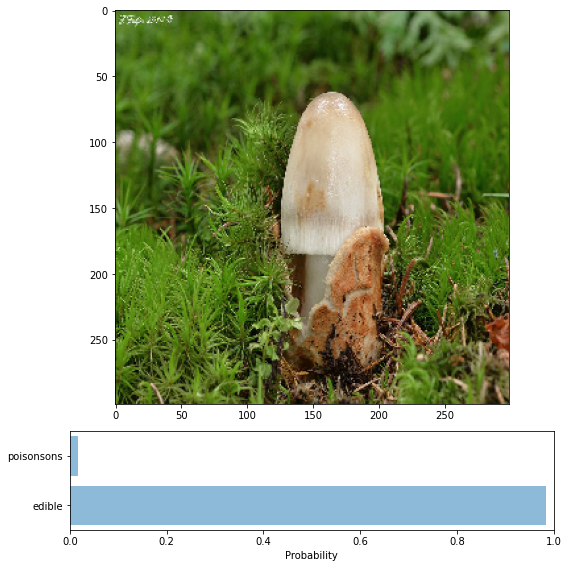

In [35]:
img = image.load_img('/content/drive/My Drive/проект/test/Ine/284_hjYnEPCzZWs.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(model_class, img)

if(preds[0]>=0.5):
  model=model_berry
  a=str(preds[0])
  print('it is berry with prediction ' + a)

if(preds[1]>=0.5):
  model=model_grib
  a=str(preds[1])
  print('it is mushroom with predicrion ' + a)

preds=predict(model,img)

plot_preds(np.asarray(img), preds)
preds

it is berry with prediction 0.99999845


array([0.13114797, 0.868852  ], dtype=float32)

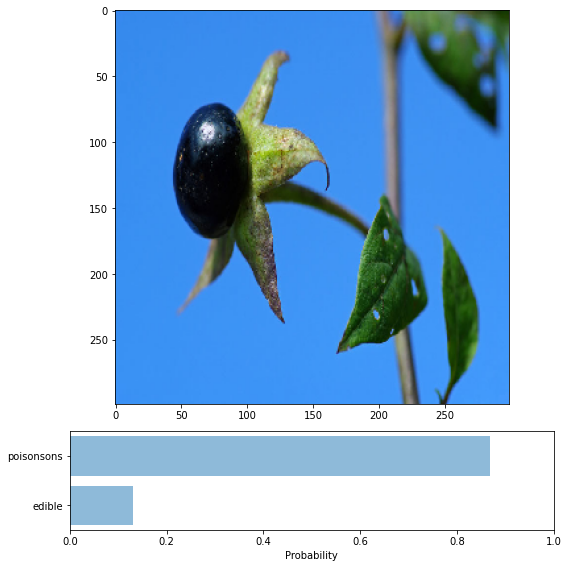

In [ ]:
img = image.load_img('/content/drive/My Drive/проект/berry_test/Ine/belladonna.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(model_class, img)

if(preds[0]>=0.5):
  model=model_berry
  a=str(preds[0])
  print('it is berry with prediction ' + a)

if(preds[1]>=0.5):
  model=model_grib
  a=str(preds[1])
  print('it is mushroom with predicrion ' + a)

preds=predict(model,img)

plot_preds(np.asarray(img), preds)
preds

array([6.749762e-07, 9.999993e-01], dtype=float32)

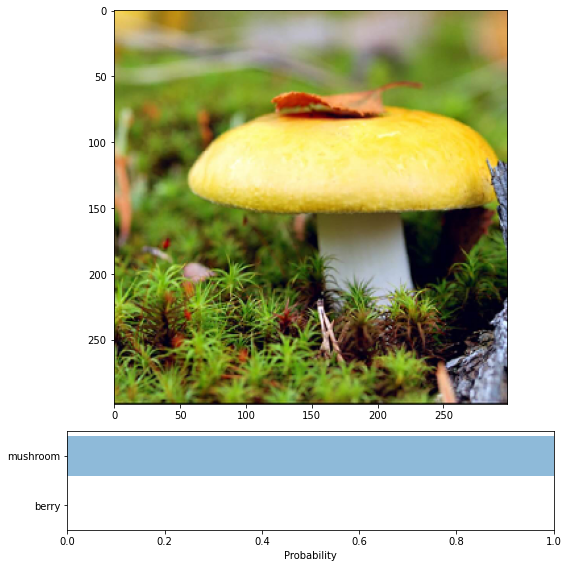

In [ ]:
img = image.load_img('/content/drive/My Drive/проект/test/Edi/kogda-sobirat-syroezhki-1024x1024.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)

plot_preds(np.asarray(img), preds)
preds

array([9.999925e-01, 7.551394e-06], dtype=float32)

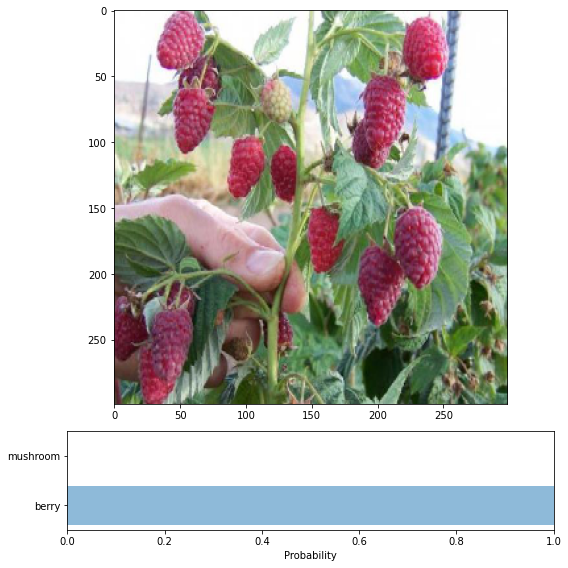

In [ ]:
img = image.load_img('/content/drive/My Drive/проект/berry_test/Edi/1-2-3.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)

plot_preds(np.asarray(img), preds)
preds